In [17]:
from __future__ import print_function

import os
import sys
sys.path.append('/home/jogi/git/repository/smart_play_set')

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import fft, arange, fftpack
from scipy import stats

from utils.smart_utils import get_dir_path, tensor_to_pandas, load_hdf5_file
from utils.smart_utils import get_array_filenames, split_on_classes, create_row_mask
from utils.smart_utils import FuturoCube, calc_cos_sim, apply_butter_filter
from preprocessing.process_data import get_data

from utils.plot_utils import plot_spectra_1axis, plot_spectra_3axis
from utils.plot_utils import plot_3axis_raw_signal_1, plot_3axis_raw_signal_compare
from utils.plot_utils import single_file_plots, load_file_to_pandas


%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
%load_ext watermark
%watermark -a "Jorg Sander" -d -v -m -p numpy,scipy,sklearn,tensorflow

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Jorg Sander 2017-01-13 

CPython 2.7.12
IPython 4.2.0

numpy 1.11.2
scipy 0.18.1
sklearn 0.18
tensorflow 0.11.0rc2

compiler   : GCC 5.4.0 20160609
system     : Linux
release    : 4.4.0-57-generic-tuxonice
machine    : x86_64
processor  : x86_64
CPU cores  : 8
interpreter: 64bit


In [18]:
Cube = FuturoCube()
walker1 = Cube.f_g_map[49]
walker2 = Cube.f_g_map[40]
print(calc_cos_sim(walker1, walker2))

2.0


### Experimental setup
* **9** children, 5 with motor derailments, 4 normal motor skills
* game device: futuro cube // game: roadrunner with 3 levels of difficulty 
* a game is 120 seconds long, level increases after 40 seconds
* sampling rate accelerometer data round 20 Hz

### Labeling of children
e.g. ID6:0:Age8:0:1 contains five labels
* ID6 = child is identified by id 6
* 0 = normal, 1 = derailed motor skills
* Age8 = child of age 8
* 0 = female, 1 = male
* 0 = left handed, 1 = right handed


### Plot 1a - Raw compared to filtered signal (time domain)

#### Note:
    * Raw time signal in blue
    * filtered signal in red
    * Applied two Butterworth filters of order 5
    * low-pass filter cutoff 2Hz, 4Hz, 6Hz, 7Hz, 8Hz, 9Hz, 10Hz


** I am only plotting the accelerometer data of one child. The signal length is 10 seconds in order to enhance the visibility of the effect of the filtering in the plots **

Each plot shows the raw (blue) and filtered (red) signal for one child, separated for the 3-axis accelerometer


2
gravity.shape  (200, 3) (200, 3)
Filtered signal (lowpass: 8 Hz order 3)


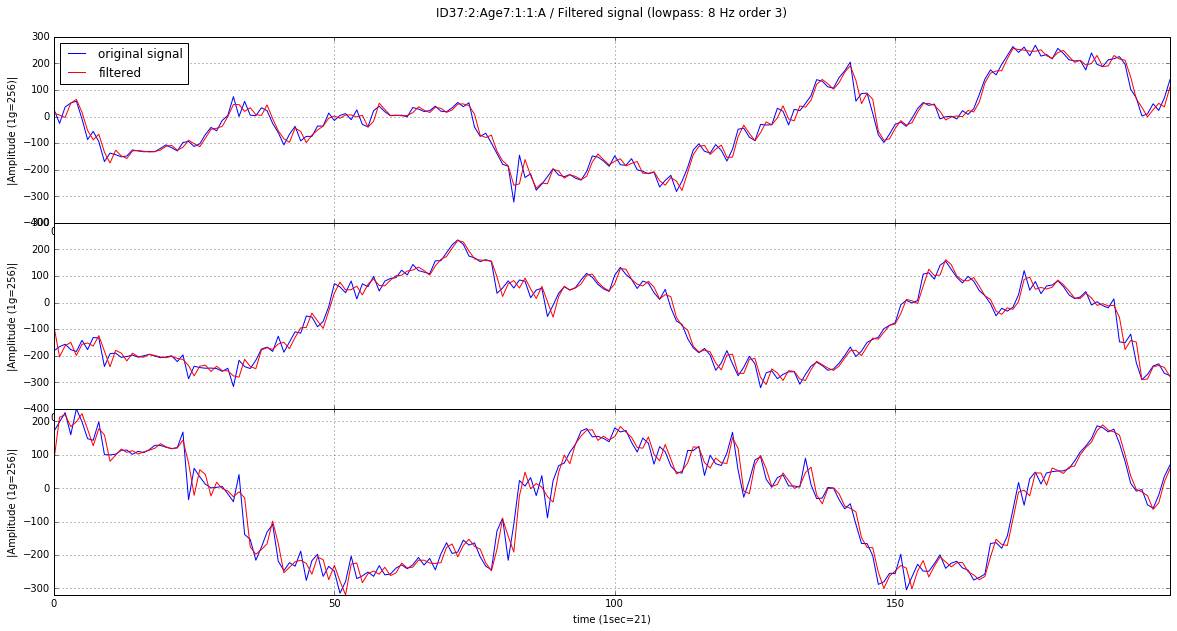

Filtered signal (lowpass: 8 Hz order 3)


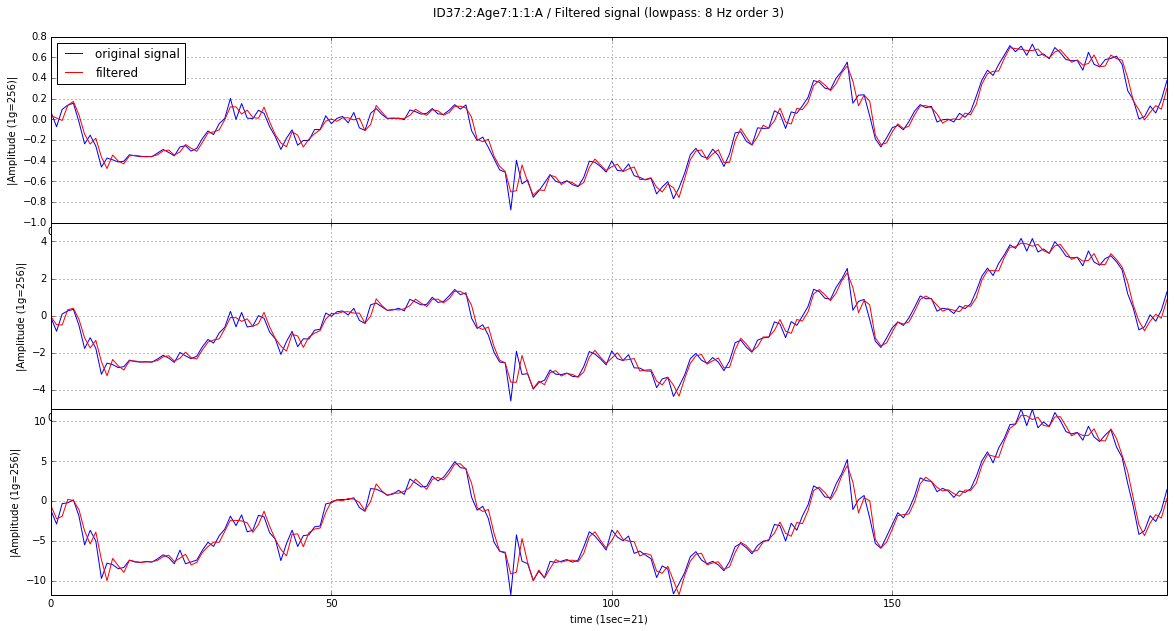

In [15]:
files = get_array_filenames('20161206', device='futurocube', game='roadrunner', sequence=1, file_ext='csv')
freq = 20.5   # Hz

# limit plots to one child
files = [files[0]]

for filename in files:
    labels = filename[filename.index('[') + 1:filename.index(']')]
    
    r_signal = (load_file_to_pandas("futurocube", "roadrunner", filename, abs_path=True)
         ).as_matrix()
    r_signal = r_signal[500:700, :]
    gravity, _ = apply_butter_filter(r_signal, freq, lowcut=1., highcut=0, f_type='low', order=3)
    print("gravity.shape ", gravity.shape, r_signal.shape)
    r_signal = r_signal - gravity
    for cutoff in [8]: # [0.3, 0.4, 0.5, 1.0]:
        single_file_plots(r_signal, freq, lowcut=cutoff, highcut=0., f_type='low', b_order=3, 
                          plot_type=1, width=20, height=10, p_legend=True,
                          add_to_title=labels + " / ",
                          apply_w_func=False, skip_dc=False, use_raw_sig=True, use_mag=False, plot_sig=[1,2])
        
        single_file_plots(gravity, freq, lowcut=cutoff, highcut=0., f_type='low', b_order=3, 
                          plot_type=1, width=20, height=10, p_legend=True,
                          add_to_title=labels + " / ",
                          apply_w_func=False, skip_dc=False, use_raw_sig=True, use_mag=False, plot_sig=[1,2])

### Plot 1b - Raw compared to filtered signal (time domain)

#### Note: 
    * plotting the 3-axis acceleromter data for all 9 children
    * using a Butterworth low-pass filter with cutoff 8Hz of order 5
    

Filtered signal (highpass: 0.3 Hz order 5)


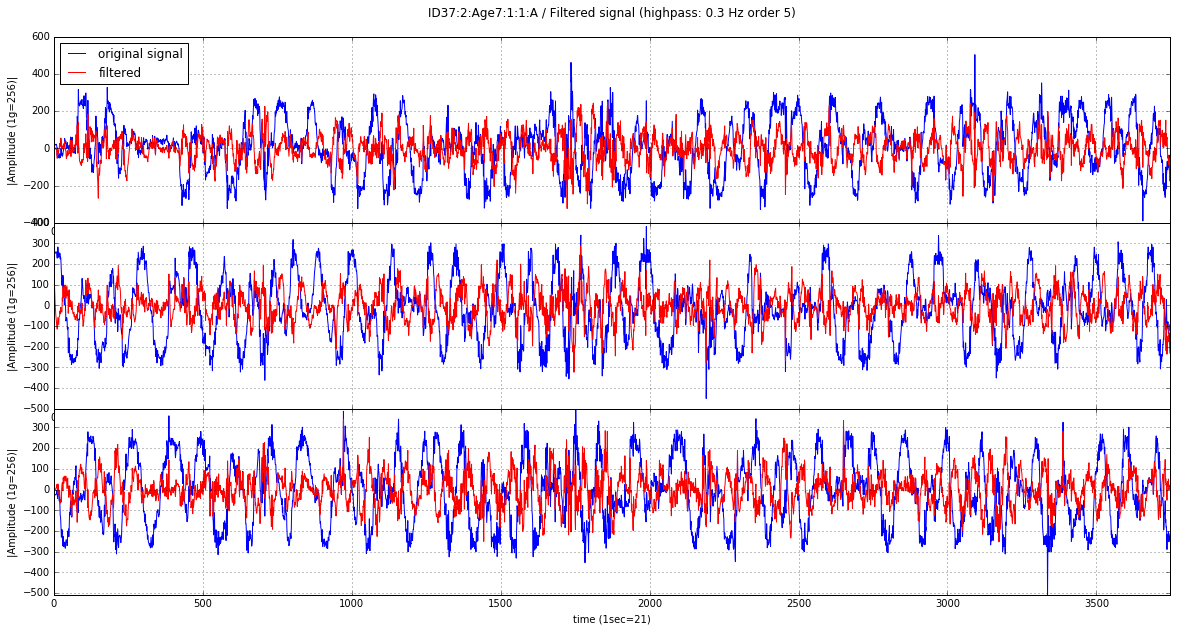

Filtered signal (highpass: 0.3 Hz order 5)


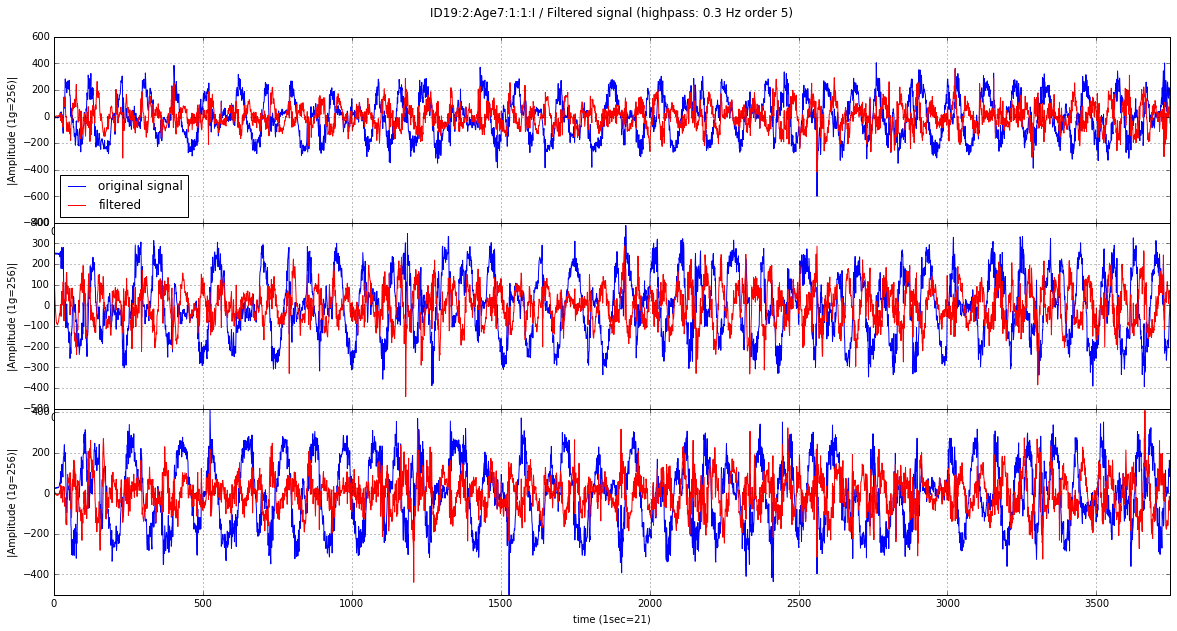

In [4]:
files = get_array_filenames('20161206', device='futurocube', game='roadrunner', sequence=1, file_ext='csv')
freq = 20   # Hz

files = files[0:2]

for filename in files:
    labels = filename[filename.index('[') + 1:filename.index(']')]
    
    r_signal = (load_file_to_pandas("futurocube", "roadrunner", filename, abs_path=True)
         ).as_matrix()

    single_file_plots(r_signal, freq, highcut=0.3, lowcut=0., f_type='high', b_order=5, 
                      plot_type=1, width=20, height=10, p_legend=True,
                      add_to_title=labels + " / ",
                      apply_w_func=False, skip_dc=True, use_raw_sig=True, use_mag=False, plot_sig=[1,2])

### Plot 2/3/4/5 - Effect of filtering and window function on signal in frequency domain

##### Note, for each child (9 in total) four plots will be shown in the following order:

####  Plot 2 - Raw signal in frequency domain

#### Plot 3 - Effect of Butterworth filter 

     Note: 
        * applied two Butterworth filters of order 5 (based on first analysis)
        * low-pass filter with 8Hz cutoff frequency
            
    
#### Plot 4 - Effect of Butterworth filter & Hamming window 

     Note:
        * applied two Butterworth filters of order 5 (based on first analysis)
        * low-pass filter with 8Hz cutoff frequency
       
        * applied ** Hamming window ** to (filtered) signal for frequency leakage prevention


#### Plot 5 - Effect of Butterworth filter & Hamming window - magnitude signal in frequency domain

    Note, instead of the 3-axis acceleromter signal these plots show the magnitude signal (one axis)
          only showing the plots for 2 children
    
        * apply Butterworth filter to 3-axis signal
        * calculate magnitude signal
    
    Plot 5a: visualizes only 40 seconds of the magnitude signal. 
                blue = original magnitude signal
                red  = filtered magnitude signal    
                
    Plot 5b: visualizes the effect of the Hamming Window function.
                      
        * apply Hamming window to magnitude signal
        * calculate FFT
        
        Important note: the DC component is omitted
        Above the plot, the first 4 FT coefficients are shown INCLUDING the DC component
        The first 2 FT components are large, question: why is the 2nd coefficients large?
                
    Plot 5c: same plot as 5b but WITHOUT applying the Hamming Window function
                Important note: the DC component is omitted
                Above the plot, the first 4 FT coefficients are shown INCLUDING the DC component

No filtering


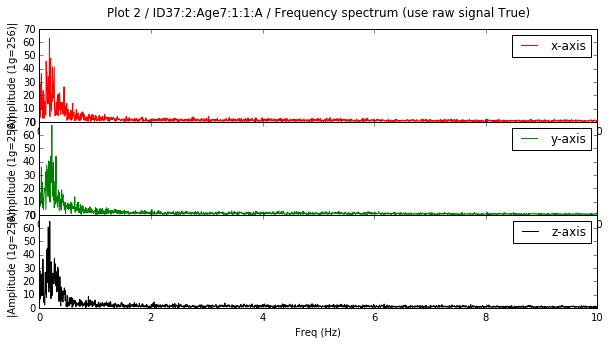

Filtered signal (lowpass: 8 Hz order 5)


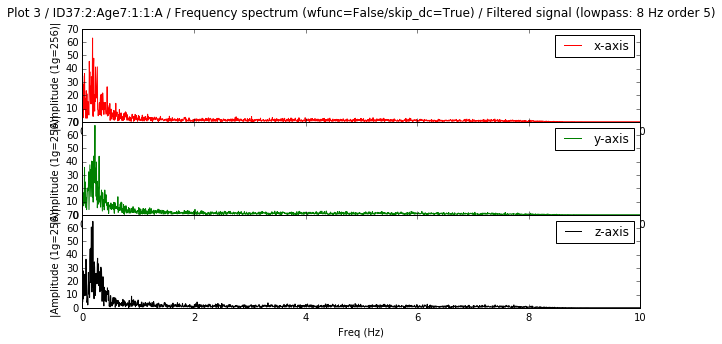

Filtered signal (lowpass: 8 Hz order 5) apply Hamming-W


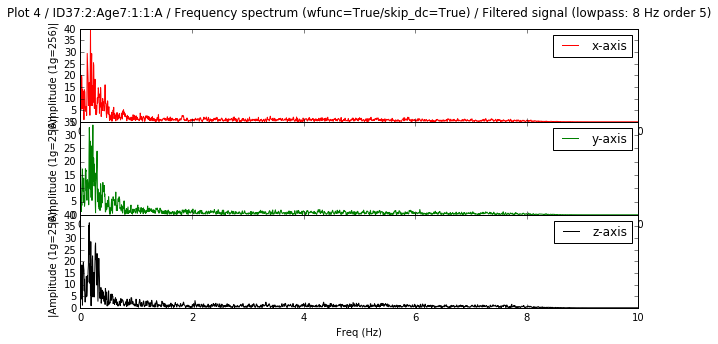

Filtered signal (lowpass: 8 Hz order 5)


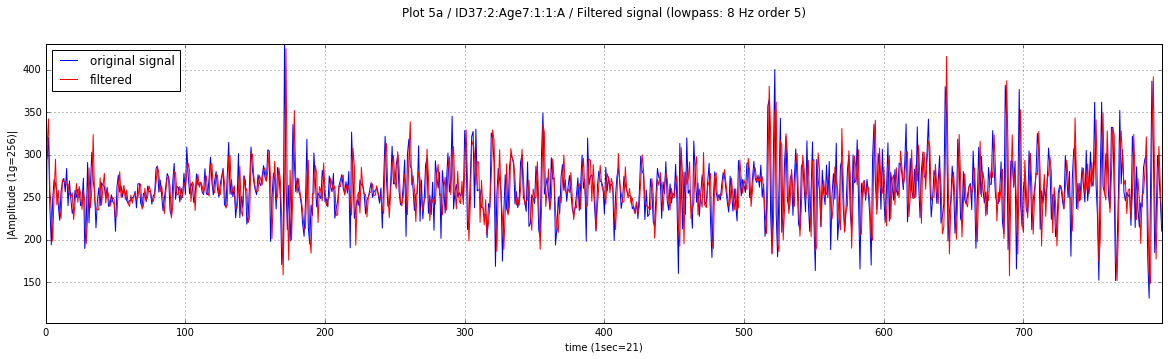

Filtered signal (lowpass: 8 Hz order 5) apply Hamming-W
Note
FFT with hamming window - first 4 freq coefficients: 280.893/120.213/1.190/0.718


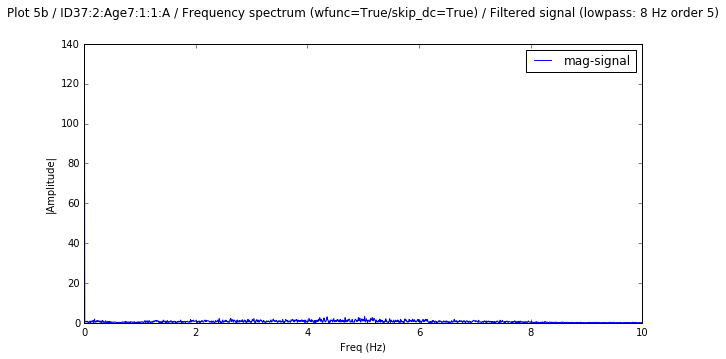

Filtered signal (lowpass: 8 Hz order 5)
Note
FFT without hamming window - first 4 freq coefficients: 519.844/0.540/1.643/0.761


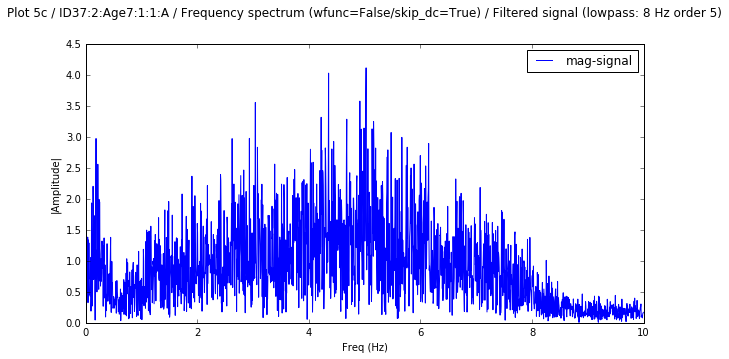

No filtering


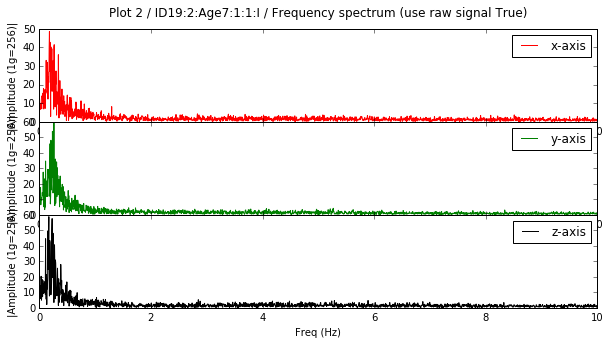

Filtered signal (lowpass: 8 Hz order 5)


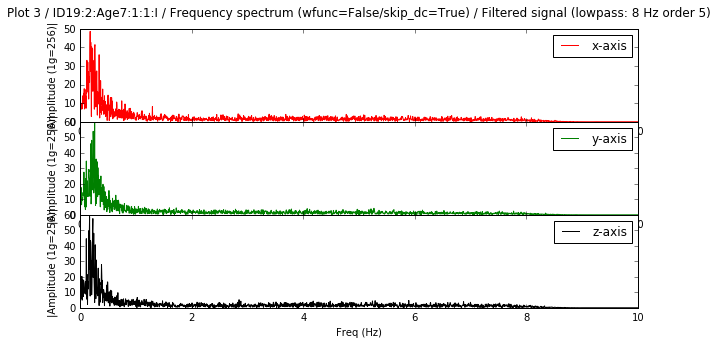

Filtered signal (lowpass: 8 Hz order 5) apply Hamming-W


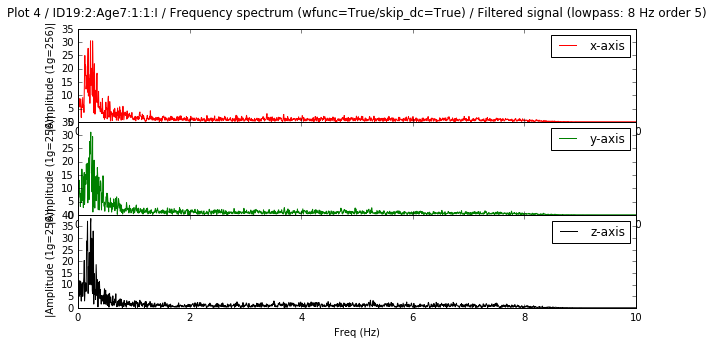

Filtered signal (lowpass: 8 Hz order 5)


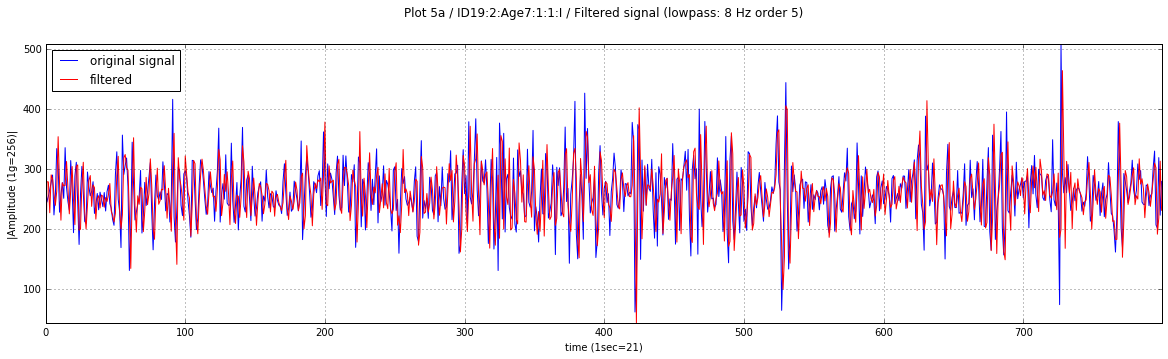

Filtered signal (lowpass: 8 Hz order 5) apply Hamming-W
Note
FFT with hamming window - first 4 freq coefficients: 281.828/119.825/0.664/0.260


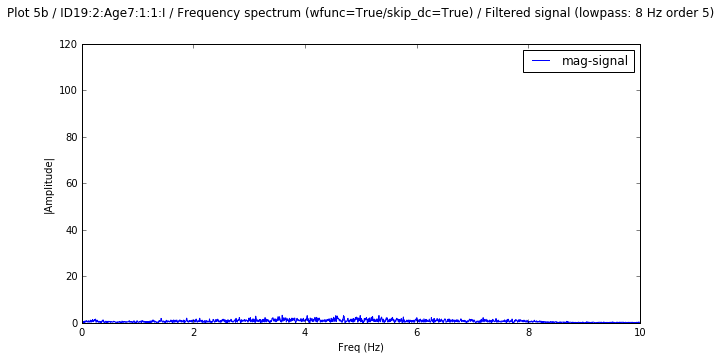

Filtered signal (lowpass: 8 Hz order 5)
Note
FFT without hamming window - first 4 freq coefficients: 522.327/1.787/0.620/0.198


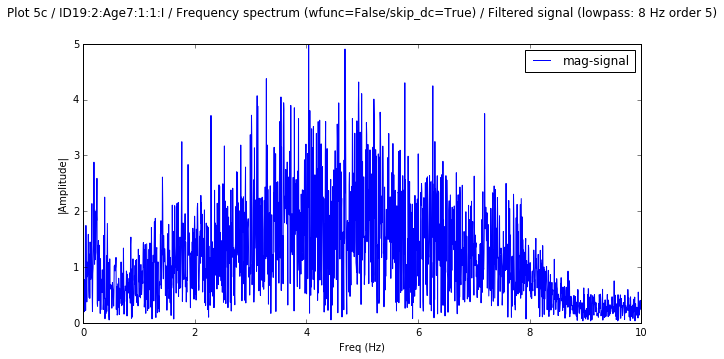

In [21]:
files = get_array_filenames('20161206', device='futurocube', game='roadrunner', sequence=1, file_ext='csv')
freq = 20   # 20 Hz
t_cufoff = 0*freq
exp_labels = []

# currently limiting the plots to 2 kids, otherwise too many of them
files = files[0:2]

for filename in files:
    labels = filename[filename.index('[') + 1:filename.index(']')] # .split(':')
    
    r_signal = (load_file_to_pandas("futurocube", "roadrunner", filename, abs_path=True)
         ).as_matrix()

    single_file_plots(r_signal, freq, f_type=None,
                      plot_type=3, width=10, height=5, p_legend=True,
                      add_to_title="Plot 2 / " + labels + " / ",
                      apply_w_func=False, skip_dc=True, use_raw_sig=True, use_mag=False)
    
    single_file_plots(r_signal, freq, highcut=0., lowcut=8.0, f_type='low', b_order=5, 
                      plot_type=3, width=10, height=5, p_legend=True,
                      add_to_title="Plot 3 / " + labels + " / ",
                      apply_w_func=False, skip_dc=True, use_raw_sig=False, use_mag=True)
    
    single_file_plots(r_signal, freq, highcut=0., lowcut=8.0, f_type='low', b_order=5, 
                      plot_type=3, width=10, height=5, p_legend=True,
                      add_to_title="Plot 4 / " + labels + " / ",
                      apply_w_func=True, skip_dc=True, use_raw_sig=False, use_mag=True)
    
    single_file_plots(r_signal[801:1601], freq, highcut=0., lowcut=8.0, f_type='low', b_order=5, 
                      plot_type=1, width=20, height=5, p_legend=True,
                      add_to_title="Plot 5a / " + labels + " / ", plot_sig=[1,2],
                      apply_w_func=False, skip_dc=False, use_raw_sig=False, use_mag=True)
    
    single_file_plots(r_signal, freq, highcut=0., lowcut=8.0, f_type='low', b_order=5, 
                      plot_type=2, width=10, height=5, p_legend=True,
                      add_to_title="Plot 5b / " + labels + " / ", 
                      apply_w_func=True, skip_dc=True, use_raw_sig=False, use_mag=True)
    
    single_file_plots(r_signal, freq, highcut=0., lowcut=8.0, f_type='low', b_order=5, 
                      plot_type=2, width=10, height=5, p_legend=True,
                      add_to_title="Plot 5c / " + labels + " / ",
                      apply_w_func=False, skip_dc=True, use_raw_sig=False, use_mag=True)

In [3]:
data, labels, other_labels, dta_descr_dict = get_data(e_date='20161206', force=False,
                                                          apply_window_func=False,
                                                          extra_label="20hz_1axis_low8hz_4731_128_False",
                                                          optimal_w_size=True, calc_mag=False,
                                                          f_type='low', lowcut=8., highcut=0.,
                                                          b_order=5,
                                                          nn_switch=True)

INFO - Used data label 20161206_futurocube_roadrunner_20hz_1axis_low8hz_4731_128_False
INFO Loading matrices from h5 file /mnt/disk2/git/repository/smart_play_set/data/futurocube/roadrunner/20161206_futurocube_roadrunner_20hz_1axis_low8hz_4731_128_False.h5
('INFO - List of arrays in this file: \n', [u'feature_data', u'label_data', u'label_game_level'])
INFO - Loading data description from json.


In [11]:
data_linear = data[:, :, 3:6]

Filtered signal (lowpass: 8 Hz order 3)


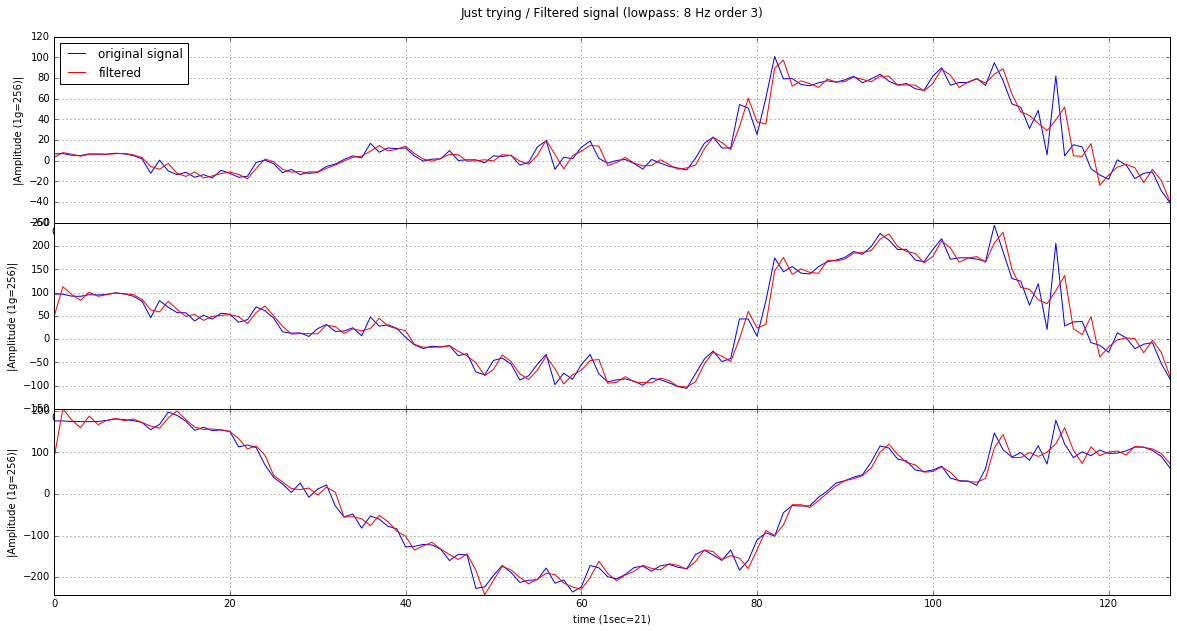

Filtered signal (lowpass: 8 Hz order 3)


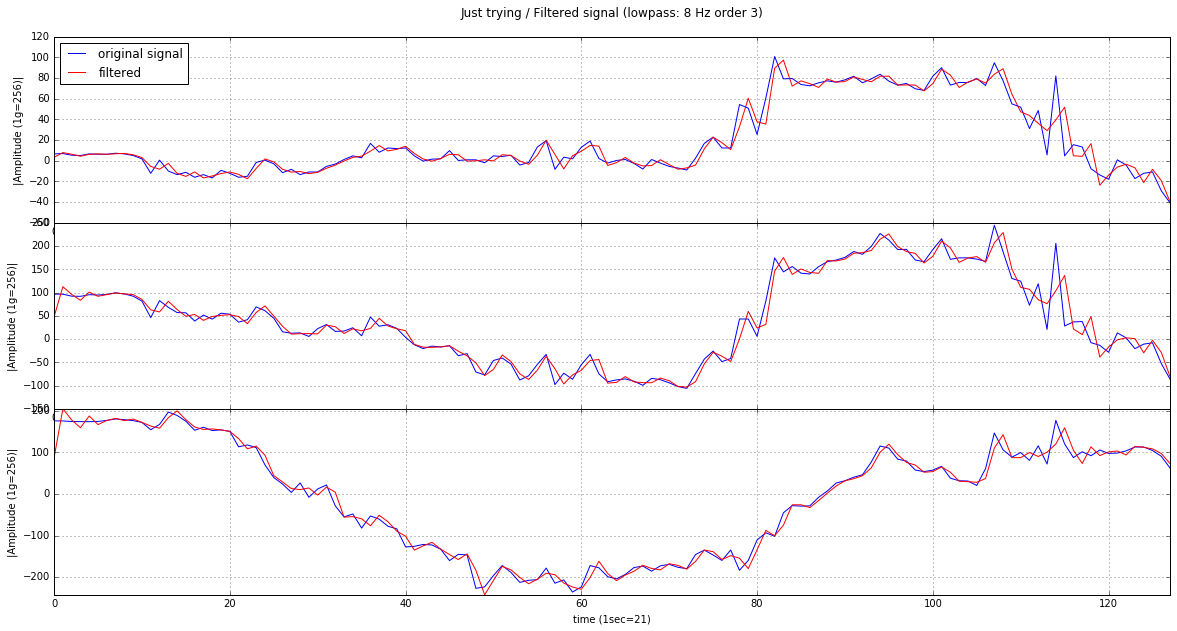

In [13]:
freq = 20.5
labels = "Just trying"
single_file_plots(data[0], freq, lowcut=8., highcut=0., f_type='low', b_order=3, 
                          plot_type=1, width=20, height=10, p_legend=True,
                          add_to_title=labels + " / ",
                          apply_w_func=False, skip_dc=False, use_raw_sig=True, use_mag=False, plot_sig=[1,2])
single_file_plots(data_linear[0], freq, lowcut=8., highcut=0., f_type='low', b_order=3, 
                          plot_type=1, width=20, height=10, p_legend=True,
                          add_to_title=labels + " / ",
                          apply_w_func=False, skip_dc=False, use_raw_sig=True, use_mag=False, plot_sig=[1,2])

labels.shape  (1925,)
Save to /home/jogi/git/repository/smart_play_set/plots/30sec_5f-tsne_projection.png


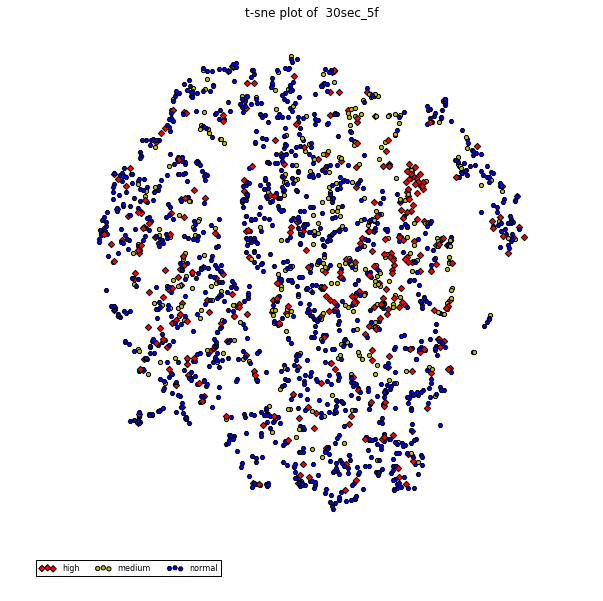

In [50]:
from sklearn.manifold import TSNE
from collections import OrderedDict

def visualize_features(features, labels, logpath='/home/jogi/git/repository/smart_play_set/plots/', prefix=None,
                       width=10, height=10):

    # mpl.use('Agg')
    # colors = ['b', 'g', 'r', 'c', 'm', 'y', '#ff6666', '#66ff66', '#6666ff', '#666666']
    colors = ['b', 'y', 'r']
    # markers = ['x', '+', '^', 'D', '<', '>', '8', '*', 'H', 'o']
    markers = ['H', '8', 'D']
    legend_labels = ['normal', 'medium', 'high']

    tsne = TSNE(n_components=2, random_state=0, learning_rate=1000)
    feature_projection = tsne.fit_transform(features)
    plot_data = np.append(feature_projection, np.expand_dims(labels, axis=1), axis=1)

    fig = plt.figure(figsize=(width, height))
    ax = fig.add_subplot(111)

    for x, y, c in plot_data.tolist():
        ax.scatter(x, y, c=colors[int(c)], marker=markers[int(c)], label=legend_labels[int(c)])

    # remove duplicates
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = OrderedDict(zip(labels, handles))
    plt.axis('off')
    plt.title("t-sne plot of  " + prefix)
    plt.legend(by_label.values(), by_label.keys(), loc='lower left', numpoints=1, ncol=5, fontsize=8)
    outfile = logpath + prefix + '-tsne_projection.png'
    print("Save to %s" % outfile)
    plt.savefig(outfile)


train_game_f = np.squeeze(train_game_f)
# level_data = train_data_f_r[train_game_f==3]
# level_labels = train_labels_f_r[train_game_f==3]
level_data = train_data_f_r
level_labels = train_labels_f_r

filtered_features = np.zeros((level_data.shape[0], 6))
filtered_features[:,0] = level_data[:, 11] # cos-sim
filtered_features[:,1] = level_data[:, 10] # power-spec-entropy
filtered_features[:,2] = level_data[:, 9] # energy
filtered_features[:,3] = level_data[:, 7] # jerk
filtered_features[:,4] = level_data[:, 1] # max
filtered_features[:,5] = level_data[:, 3] # stdev

labels = level_labels.astype(float)
# labels[labels == 2.] = 1.

print("labels.shape ", labels.shape)
visualize_features(filtered_features, labels, prefix="30sec_5f")

In [38]:
print(train_labels_f_r.shape)

(330,)


### Plot 6 - Feature values per game level/window for both motor skill classes

#### Note: 
* the following features were calculated in the time domain:
        min, max, mean, std, median, range, rms, integrated_squared_jerk
* the following features were calculated in the frequency domain:
        DC, energy, power-spectrum-entropy
* the following features were calculated for the game state information:
        dx/dy sum of squared errors
* the plots underneath show for each feature the values for both motor skill classes (for 9 children)
* the x-axis is labeled as "Window", in this case a window is equivalent to a game level (three levels) which lasted 40 seconds
* class 0 = normal motor skills, class 1 = derailed motor skills

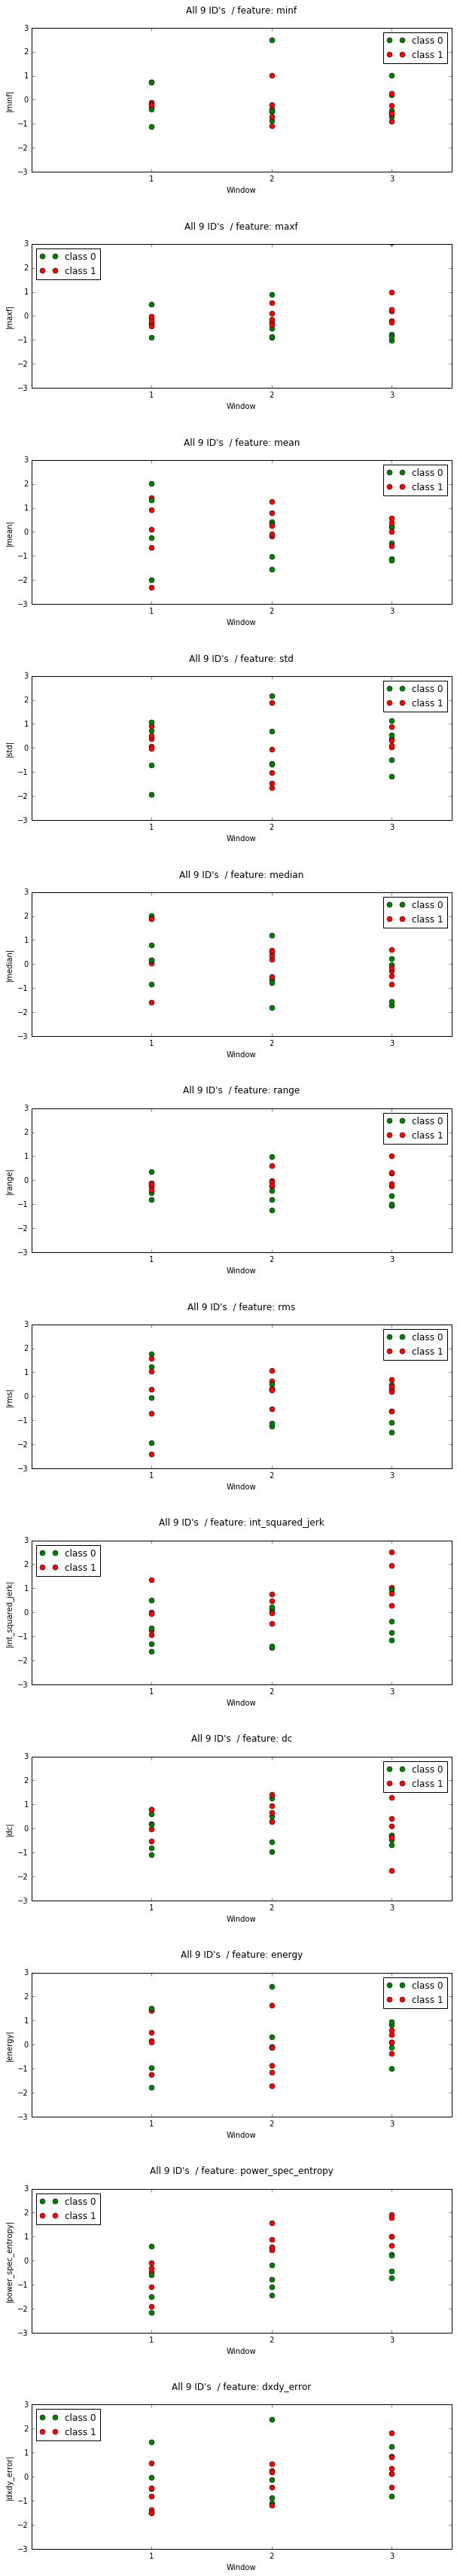

In [10]:
num_of_files = int(dta_dict_f["num_of_files"])
label_dicts = dta_dict_f["id_attributes"]


plot_one_feature_v2(dta_train_subset, num_of_windows-2, 9, label_dicts, features=feature_list, f_index=-1,  
                       p_legend=True, width=10, height=60)

### Plot 7 - Average feature values per game level/window for both motor skill classes

#### Note: 
* the following features were calculated in the time domain:
        min, max, mean, std, median, range, rms, integrated_squared_jerk
* the following features were calculated in the frequency domain:
        DC, energy, power-spectrum-entropy
* the following features were calculated for the game state information:
        dx/dy sum of squared errors
* the plots underneath show the **average** feature values per game level for both motor skill classes
* the x-axis is labeled as "Window", in this case a window is equivalent to a game level (three levels)
* the errorbars visualize the standard deviation
* class 0 = normal motor skills, class 1 = derailed motor skills

t-test for Class 1 group, comparing mean2 with mean3, p-value=0.84652
t-test for Class 1 group, comparing mean2 with mean3, p-value=0.90665
t-test for Class 1 group, comparing mean2 with mean3, p-value=0.78428
t-test for Class 1 group, comparing mean2 with mean3, p-value=0.52048
t-test for Class 1 group, comparing mean2 with mean3, p-value=0.48113
t-test for Class 1 group, comparing mean2 with mean3, p-value=0.92912
t-test for Class 1 group, comparing mean2 with mean3, p-value=0.89921
t-test for Class 1 group, comparing mean2 with mean3, p-value=0.08685
t-test for Class 1 group, comparing mean2 with mean3, p-value=0.87071
t-test for Class 1 group, comparing mean2 with mean3, p-value=0.61934
t-test for Class 1 group, comparing mean2 with mean3, p-value=0.61914
t-test for Class 1 group, comparing mean2 with mean3, p-value=0.17251
t-test for Class 1 group, comparing mean2 with mean3, p-value=0.26680


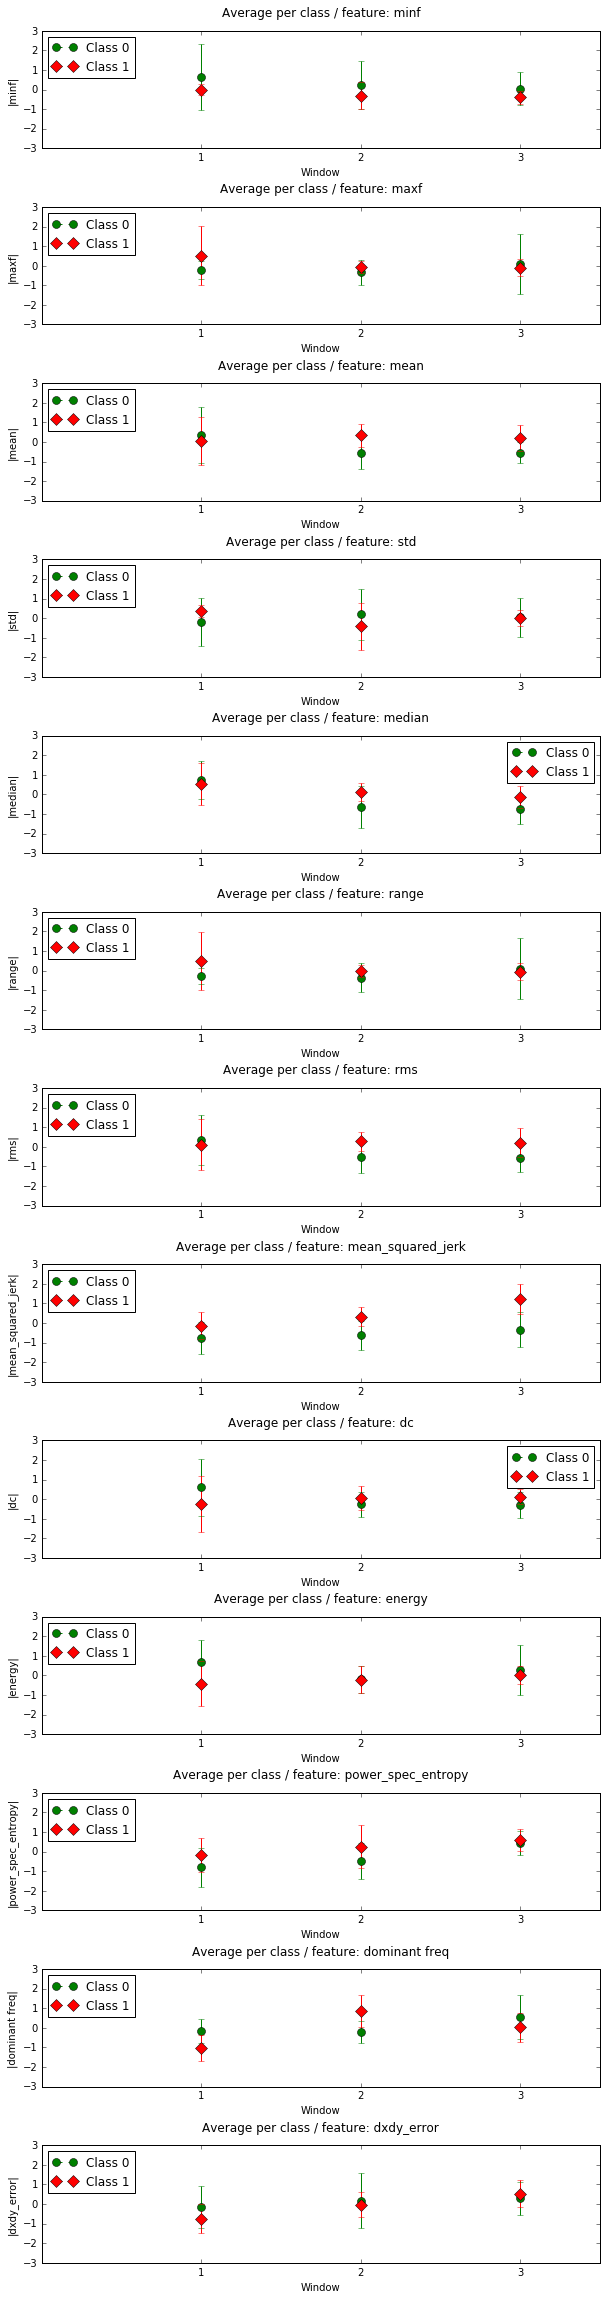

In [24]:
res = split_on_classes(dta_train_subset, np.reshape(lbl_train_subset, (lbl_train_subset.shape[0], 1)))
num_of_files = int(dta_dict_f["num_of_files"])
label_dicts = dta_dict_f["id_attributes"]

plot_one_feature_v3(res[0], res[1], num_of_windows, [0, 1], features=feature_list, f_index=-1,  
                       p_legend=True, width=10, height=5)

In [5]:
def plot_one_feature(data1, label1, f_index, features, data2=None, label2="", width=20, height=10, 
                           p_legend=False, xyz_axis=True):
    
    feature = features[f_index]
    data1 = np.reshape(data1[:, f_index, :], (data1.shape[0], data1.shape[2]))
    if data2 is not None:
        data2 = np.reshape(data2[:, f_index, :], (data2.shape[0], data2.shape[2]))
        p_title = label1 + " & " + label2 + " / feature: " + feature
    else:
        p_title = label1 + " / feature: " + feature
        
    t = np.arange(data1.shape[0])
    y_label = "|" + feature + "|"
    x_label = "|window|"
    
    plt.figure(figsize=(width, height))
    if xyz_axis:
        ax1 = plt.subplot(3, 1, 1)
    else:
        ax1 = plt.subplot(1, 1, 1)
        
    plt.title(p_title, y=1.08)

    plt.plot(t, data1[:, 0], label='x-axis ' + label1)
    if data2 is not None:
        plt.plot(t, data2[:, 0], label='x-axis ' + label2, color='r')
    plt.xlabel(x_label)
    plt.grid(True)
    plt.ylabel(y_label)
    if p_legend:
        plt.legend(loc="best")
    
    if xyz_axis:
        plt.subplot(3, 1, 2, sharex=ax1)
        plt.plot(t, data1[:, 1], label='y-axis ' + label1)
        if data2 is not None:
            plt.plot(t, data2[:, 1], label='y-axis ' + label2, color='r')
        plt.xlabel(x_label)
        plt.grid(True)
        plt.ylabel(y_label)
        if p_legend:
            plt.legend(loc="best")

        plt.subplot(3, 1, 3, sharex=ax1)
        plt.plot(t, data1[:, 2], label='z-axis ' + label1)
        if data2 is not None:
            plt.plot(t, data2[:, 2], label='z-axis ' + label2, color='r')
        plt.xlabel(x_label)
        plt.grid(True)
        plt.ylabel(y_label)
        if p_legend:
            plt.legend(loc="best")

    plt.axis('tight')
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()

In [70]:
def plot_one_feature_v2(data, num_of_windows, n_files, l_dict, features, f_index=-1, width=20, height=10, 
                           p_legend=False, do_save=False):
    
    
    feature = features[f_index]
    t = np.arange(1, num_of_windows+1)
    x_label = "|window|"
    
    if f_index==-1:
        f_range = np.arange(len(features))
        if height < 40:
            height = 40
    else:
        f_range = [f_index]
        
    plt.figure(figsize=(width, height))
    plt.gca().set_autoscale_on(False)
    
    dta_0 = None
    dta_1 = None
    first_plot = True
        
    for i, f_idx in enumerate(f_range):
        feature = features[f_idx]
        y_label = "|" + feature + "|"
        ax1 = plt.subplot(len(f_range), 1, i+1)
        plt.ylabel(y_label)
        p_title = "All %d ID's " % n_files + " / feature: " +  feature
        if do_save:
            plt.title("Standardized " + feature + " values for each child per window/segment")
        else:
            plt.title(p_title, y=1.08)
        plt.xticks(t, t)
        plt.xlabel("Window")
    
        for idx in np.arange(n_files):
            offset = int(idx*num_of_windows)
            dta = np.reshape(data[offset:offset+num_of_windows, f_idx, :], (num_of_windows, data.shape[2]))

            label = "class %s" % l_dict[idx]["CLASS"]
            if l_dict[idx]["CLASS"] == '0':
                p_color = 'g'
                cls1, = plt.plot(t, dta[:, 0], color=p_color, marker='o', linestyle='--', markersize=7, 
                            label=label)
            else:
                p_color = 'r'
                cls2, = plt.plot(t, dta[:, 0], color=p_color, marker='o', linestyle='--', markersize=7,
                            label=label)
            
            plt.xlim([0, num_of_windows + 0.5])
            plt.ylim([-3,3])
        if p_legend and first_plot:
            ax1.legend(handles=[cls1, cls2], loc="best")
        else:
            first_plot = False

        # plt.axis('tight')
        plt.subplots_adjust(wspace=0, hspace=0.5)
    
    if do_save:
        f_name = "/home/jogi/git/repository/smart_play_set/images/" + "f_per_win_id" + ".jpg"
        plt.savefig(f_name, bbox_inches='tight')
    else:
        plt.show()

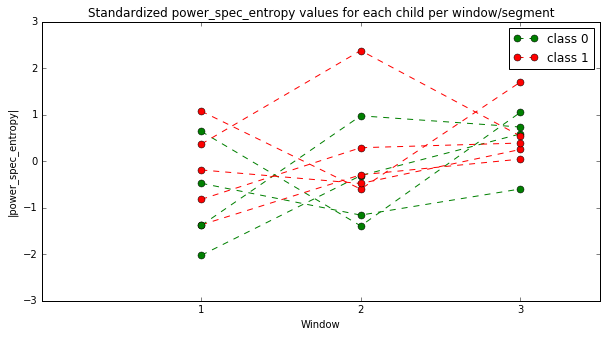

In [73]:
num_of_files = int(dta_dict_f["num_of_files"])
label_dicts = dta_dict_f["id_attributes"]


plot_one_feature_v2(dta_train_subset, num_of_windows, 9, label_dicts, features=feature_list, f_index=10,  
                       p_legend=True, width=10, height=5, do_save=True)

In [48]:
def plot_one_feature_v3(dta1, dta2, num_of_windows, labels, features, f_index=-1, width=20, height=10, 
                           p_legend=False):
    
    
    if f_index==-1:
        f_range = np.arange(len(features))
        if height < 40:
            height = 40
    else:
        f_range = [f_index]
        
    t = np.arange(1, num_of_windows+1)
    x_label = "|window|"
    
    plt.figure(figsize=(width, height))

    plt.gca().set_autoscale_on(False)
    plt.xlabel(x_label)
    label1 = "Class %d" % labels[0]
    label2 = "Class %d" % labels[1]
    dta1_dim1 = int(dta1.shape[0] / num_of_windows)
    dta2_dim1 = int(dta2.shape[0] / num_of_windows)
    first_plot = True
    
    for i, f_idx in enumerate(f_range):
        feature = features[f_idx]
        y_label = "|" + feature + "|"
        ax1 = plt.subplot(len(f_range), 1, i+1)
        plt.ylabel(y_label)
        p_title = "Average per class" + " / feature: " + feature   
        plt.title(p_title, y=1.08)
        plt.xticks(t, t)
        plt.xlabel("Window")
        measures_class0 = []
        measures_class1 = []
        for idx in np.arange(num_of_windows):

            dta1_m = np.reshape(dta1[idx::num_of_windows, f_idx, :], (dta1_dim1, dta1.shape[2]))
            dta2_m = np.reshape(dta2[idx::num_of_windows, f_idx, :], (dta2_dim1, dta2.shape[2]))  
            measures_class0.append(dta1_m)
            measures_class1.append(dta2_m)
            dta1_err = dta1_m.std(axis=0)
            dta2_err = dta2_m.std(axis=0)
            dta1_m = dta1_m.mean(axis=0)
            dta2_m = dta2_m.mean(axis=0)

            cls1, = plt.plot(t[idx], dta1_m, color='g', marker='o', linestyle='None', markersize=8, label=label1)
            plt.errorbar(t[idx], dta1_m, yerr=dta1_err, fmt='g')
            cls2, = plt.plot(t[idx], dta2_m, color='r', marker='D', linestyle='None', 
                                 markersize=8, label=label2)
            plt.errorbar(t[idx], dta2_m, yerr=dta2_err, fmt='r')
        
            plt.xlim([0, num_of_windows + 0.5])
            plt.ylim([-3,3])
            
        
        means_class0 = np.array(measures_class0).mean(axis=1)
        means_class1 = np.array(measures_class1).mean(axis=1)
        plt.plot(t, means_class0, linestyle='--', color='g')
        plt.plot(t, means_class1, linestyle='--', color='r')
        # calculate t-test
        t_value, p_value = stats.ttest_ind(measures_class0[1], measures_class0[2], equal_var=False)
        print("t-test for " + label1 + " group, comparing mean2 with mean3, p-value=%.5f" % p_value)
        
        if p_legend:
            plt.legend(handles=[cls1, cls2], loc="best")

    
    # plt.axis('tight')
    plt.subplots_adjust(wspace=0, hspace=0.5)
    plt.show()

In [6]:
files = get_array_filenames('20160921', device='futurocube', game='roadrunner', sequence=1, file_ext='csv')
freq = 20   # 20 Hz
t_cufoff = 0*freq
exp_labels = []

# currently limiting the plots to 2 kids, otherwise too many of them
filename = files[0]
print(filename)
labels = filename[filename.index('[') + 1:filename.index(']')] # .split(':')
    
r_signal = (load_file_to_pandas("futurocube", "roadrunner", filename, abs_path=True)
         ).as_matrix()

single_file_plots(r_signal[801:881], freq, lowcut=8, f_type='low', b_order=5, 
                      plot_type=1, width=20, height=5, p_legend=True,
                      add_to_title="Plot 5a / " + labels + " / ", plot_sig=[1,2],
                      apply_w_func=False, skip_dc=False, use_raw_sig=False, use_mag=True)

/home/jogi/git/repository/smart_play_set/data/futurocube/roadrunner/20160921_futurocube_roadrunner_[ID6:0:Age8:0:1]_acc.csv
Filtered signal (lowpass: 8 Hz order 5)


t-test for Class 0 group, comparing mean2 with mean3, p-value=0.21317


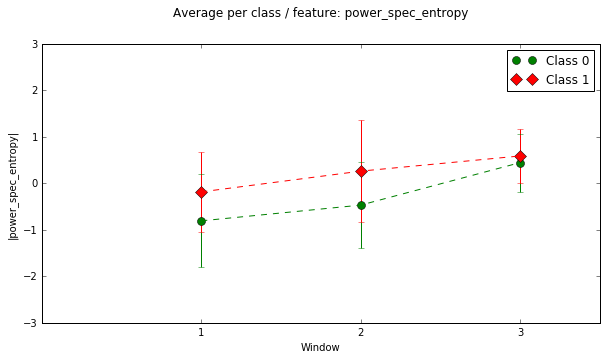

In [58]:
res = split_on_classes(dta_train_subset, np.reshape(lbl_train_subset, (lbl_train_subset.shape[0], 1)))
num_of_files = int(dta_dict_f["num_of_files"])
label_dicts = dta_dict_f["id_attributes"]

plot_one_feature_v3(res[0], res[1], num_of_windows, [0, 1], features=feature_list, f_index=10,  
                       p_legend=True, width=10, height=5)